In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from time import time
import matplotlib.pyplot as plt
from figure_manager import FigureManager
from plots import *

import DynamicTimeAllocationModel

path = 'output/'

fm = FigureManager(path, use_latex=False)

# c++ settings
do_compile = True
threads = 50

# from EconModel import cpptools
# cpptools.setup_nlopt(folder='cppfuncs/', do_print=True)

TO DO (precomputation):
1. Thorough test that it works
2. Numerical inverse?


Have done:
1. New model setup in py-file
2. Precomputation of intratemporal allocation for singles
3. Precompute marginal utility for singles
4. Precomputation of intratemporal allocation for couples
5. Precomputation of marginal utility for couples 
6. Fix imprecision issues at the bottom of the Ctot grid (bit ad hoc but it sort of works)

# Solve and simulate from alternative models

Benchmark model settings

In [2]:
settings = { 
       'T':9,
       'num_A': 50,
       'num_A_pd': 100,
       'num_K': 2,
       'num_power': 21,
       'num_love': 11,
       
       'simN': 1000,

       'num_Ctot': 120,
       'num_marg_u':120,

       'phi_w': 1.0,
       'phi_m': 1.0,
       
       'p_meet': 0.0,

       'threads':threads,
       
       'do_egm': False,
       'interp_method': 'linear',
       'interp_inverse': False,
       
       'precompute_intratemporal': True,
       'centered_gradient': True,
       }

In [3]:
show_iEGM = True
show_VFI = True
show_numEGM = False
show_iEGMinv = False

In [6]:
if show_iEGM:
    settings_iEGM = settings.copy()
    settings_iEGM['do_egm'] = True
    settings_iEGM['interp_method'] = 'linear'
    settings_iEGM['interp_inverse'] = False
    
    model_iEGM = DynamicTimeAllocationModel.HouseholdModelClass(par=settings_iEGM)
    model_iEGM.link_to_cpp(force_compile=do_compile)
    
    %time model_iEGM.solve()
    #%time model_iEGM.simulate()
    %time model_iEGM.find_optimal_decision()
    
    model_iEGM.cpp.delink()

CPU times: total: 16.9 s
Wall time: 1.3 s
CPU times: total: 0 ns
Wall time: 7.99 ms


In [7]:
if show_VFI:
    settings_VFI = settings.copy()
    settings_VFI['do_egm'] = False
    
    model_VFI = DynamicTimeAllocationModel.HouseholdModelClass(par=settings_VFI)
    model_VFI.link_to_cpp(force_compile=do_compile)
    
    %time model_VFI.solve()
    %time model_VFI.simulate()
    %time model_VFI.find_optimal_decision()

    model_VFI.cpp.delink()

CPU times: total: 1min 43s
Wall time: 6.47 s
CPU times: total: 0 ns
Wall time: 5.02 ms
CPU times: total: 15.6 ms
Wall time: 8.96 ms


In [8]:
if show_numEGM:
    settings_numEGM = settings.copy()
    settings_numEGM['do_egm'] = True
    settings_numEGM['interp_method'] = 'numerical'
    
    model_numEGM = DynamicTimeAllocationModel.HouseholdModelClass(par=settings_numEGM)
    model_numEGM.link_to_cpp(force_compile=do_compile)
    
    %time model_numEGM.solve()
    %time model_numEGM.simulate()
    %time model_numEGM.find_optimal_decision()
    
    model_numEGM.cpp.delink()

In [9]:
if show_iEGMinv:
    settings_iEGMinv = settings.copy()
    settings_iEGMinv['do_egm'] = True
    settings_iEGMinv['interp_method'] = 'linear'
    settings_iEGMinv['interp_inverse'] = True
    
    model_iEGMinv = DynamicTimeAllocationModel.HouseholdModelClass(par=settings_iEGMinv)
    model_iEGMinv.link_to_cpp(force_compile=do_compile)
    
    %time model_iEGMinv.solve()
    %time model_iEGMinv.simulate()
    %time model_iEGMinv.find_optimal_decision()

    model_iEGMinv.cpp.delink()

Setup plotters

In [10]:
if show_iEGM:    mp_iEGM = model_plotter(model_iEGM, model_name='iEGM', titles=['variable'], labels=['model', 'index'])
if show_VFI:     mp_VFI = model_plotter(model_VFI, model_name='VFI', titles=['variable'], labels=['model', 'index'])
if show_numEGM:  mp_numEGM = model_plotter(model_numEGM, model_name='numEGM', titles=['variable'], labels=['model', 'index'])
if show_iEGMinv: mp_iEGMinv = model_plotter(model_iEGMinv, model_name='iEGMinv', titles=['variable'], labels=['model', 'index'])

grid = 'grid_A'
idx = {'t': 0, 'il':2, 'iP': 7, 'iL': 5, 'iA': 30, 'iA_pd': 60}
t, iP, iL, iA = idx['t'], idx['iP'], idx['iL'], idx['iA']

## Singles solution

Saved full figure to output\female_single_choices.pdf
Saved subplot to output\female_single_choices_subplot_1.pdf
Saved subplot to output\female_single_choices_subplot_2.pdf
Saved subplot to output\female_single_choices_subplot_3.pdf
Saved subplot to output\female_single_choices_subplot_4.pdf
Saved subplot to output\female_single_choices_subplot_5.pdf
Saved subplot to output\female_single_choices_subplot_6.pdf


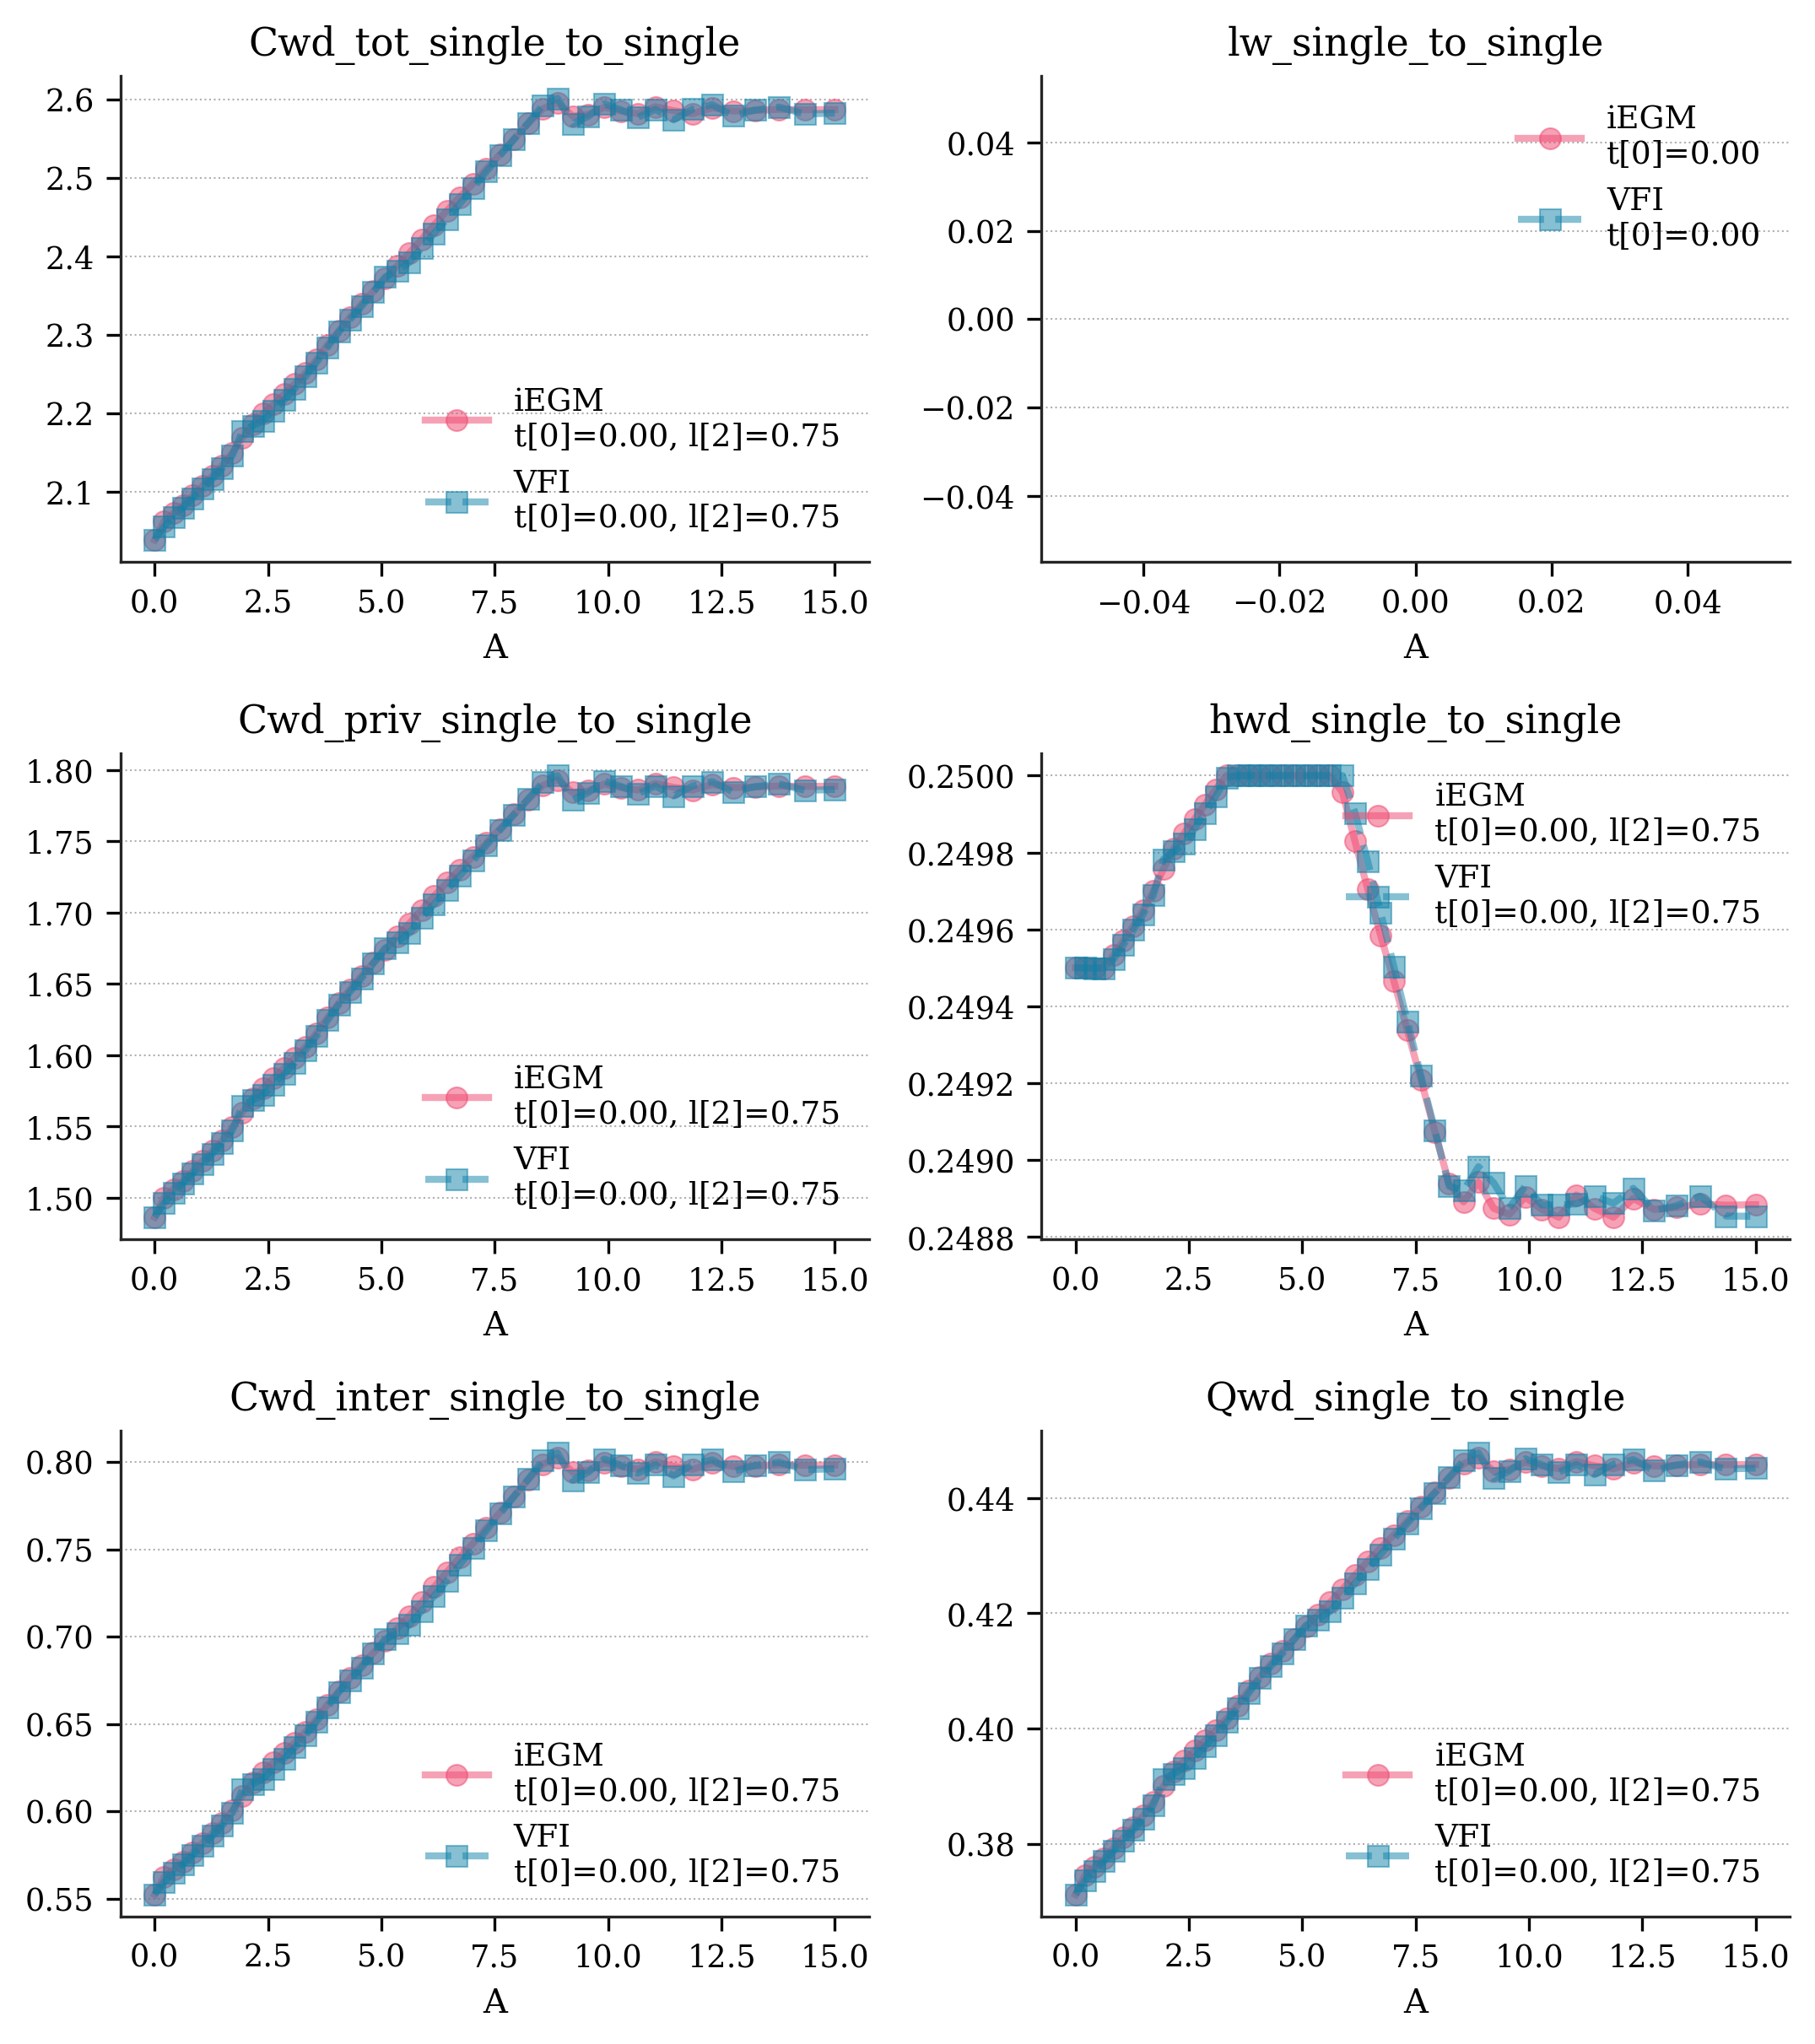

In [11]:
fig, ax = fm.create_figure(3,2,6)
if show_iEGM:    mp_iEGM.plot_female_single_choices(ax, grid=grid, index=idx, alpha=0.5)
if show_VFI:     mp_VFI.plot_female_single_choices(ax, grid=grid, index=idx, alpha=0.5)
if show_numEGM:  mp_numEGM.plot_female_single_choices(ax, grid=grid, index=idx, alpha=0.5)
if show_iEGMinv: mp_iEGMinv.plot_female_single_choices(ax, grid=grid, index=idx, alpha=0.5)
fm.save_figure(filename="female_single_choices")

Saved full figure to output\female_single_values.pdf
Saved subplot to output\female_single_values_subplot_1.pdf
Saved subplot to output\female_single_values_subplot_2.pdf
Saved subplot to output\female_single_values_subplot_3.pdf
Saved subplot to output\female_single_values_subplot_4.pdf
Saved subplot to output\female_single_values_subplot_5.pdf
Saved subplot to output\female_single_values_subplot_6.pdf


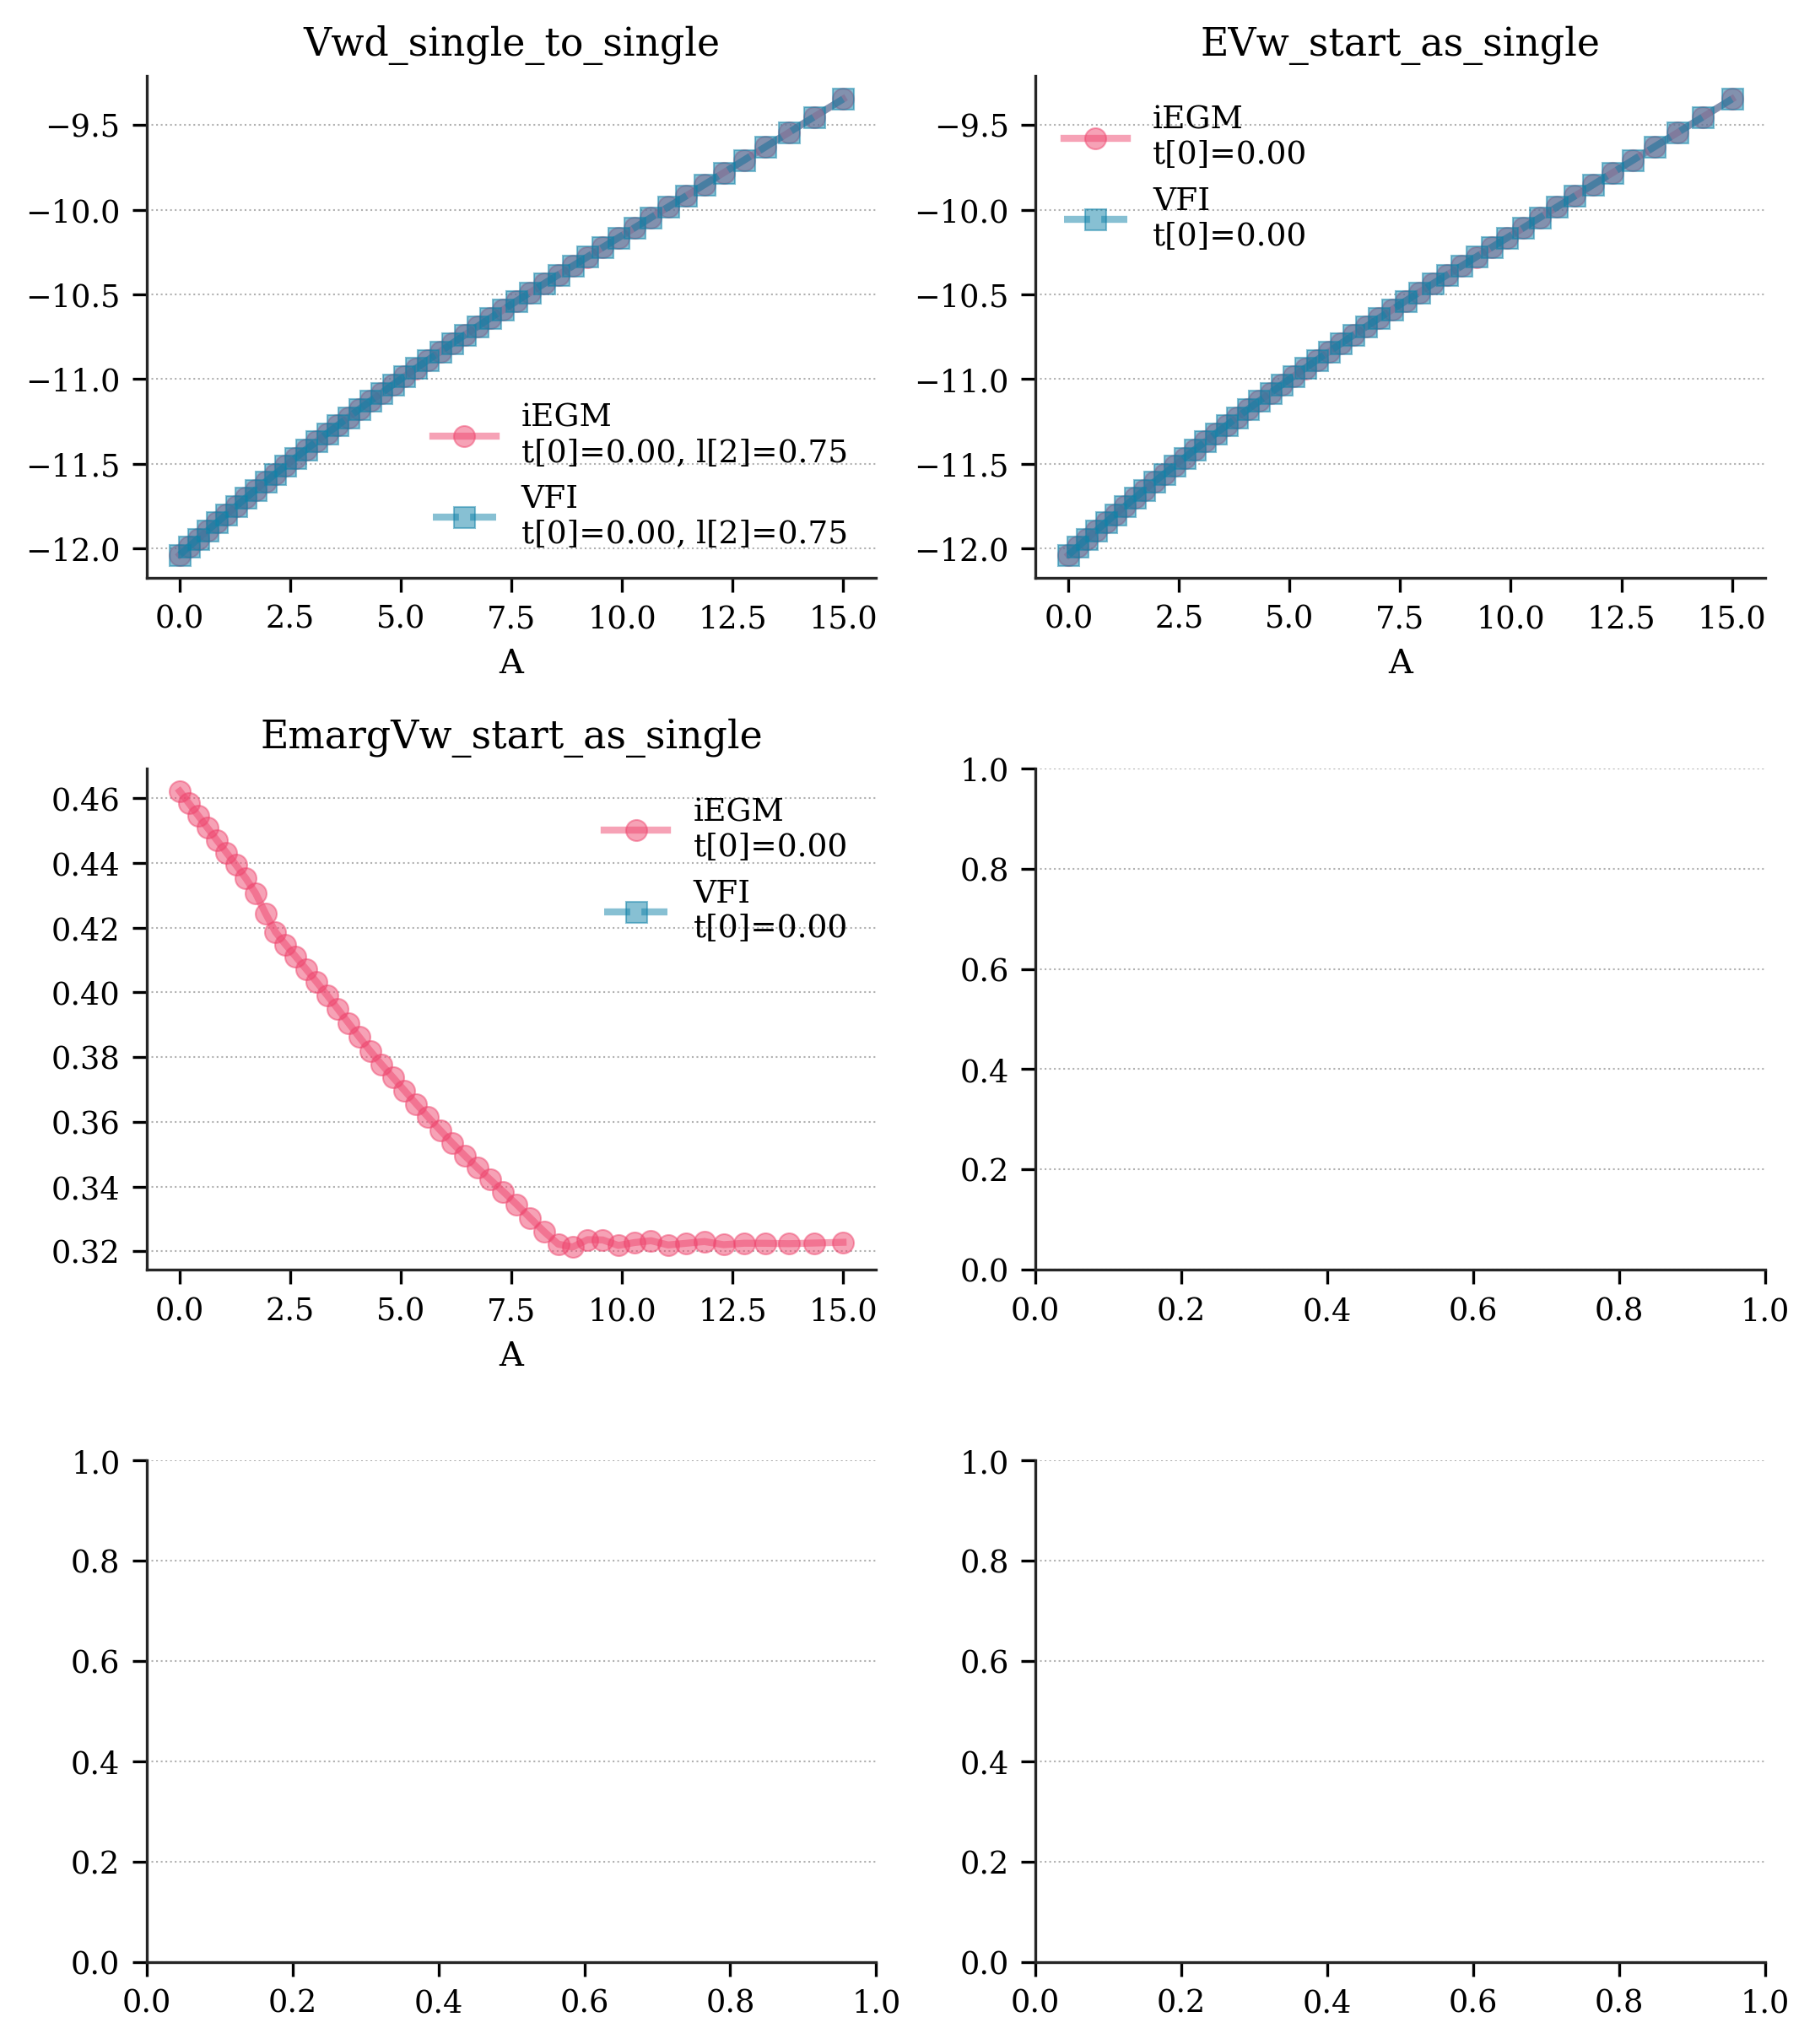

In [12]:
fig, ax = fm.create_figure(3,2,6)
if show_iEGM:    mp_iEGM.plot_female_single_values(ax, grid=grid, index=idx, alpha=0.5)
if show_VFI:     mp_VFI.plot_female_single_values(ax, grid=grid, index=idx, alpha=0.5)
if show_numEGM:  mp_numEGM.plot_female_single_values(ax, grid=grid, index=idx, alpha=0.5)
if show_iEGMinv: mp_iEGMinv.plot_female_single_values(ax, grid=grid, index=idx, alpha=0.5)
fm.save_figure(filename="female_single_values")

## Couples solution

Saved full figure to output\gender_couple_choices.pdf
Saved subplot to output\gender_couple_choices_subplot_1.pdf
Saved subplot to output\gender_couple_choices_subplot_2.pdf
Saved subplot to output\gender_couple_choices_subplot_3.pdf
Saved subplot to output\gender_couple_choices_subplot_4.pdf
Saved subplot to output\gender_couple_choices_subplot_5.pdf
Saved subplot to output\gender_couple_choices_subplot_6.pdf


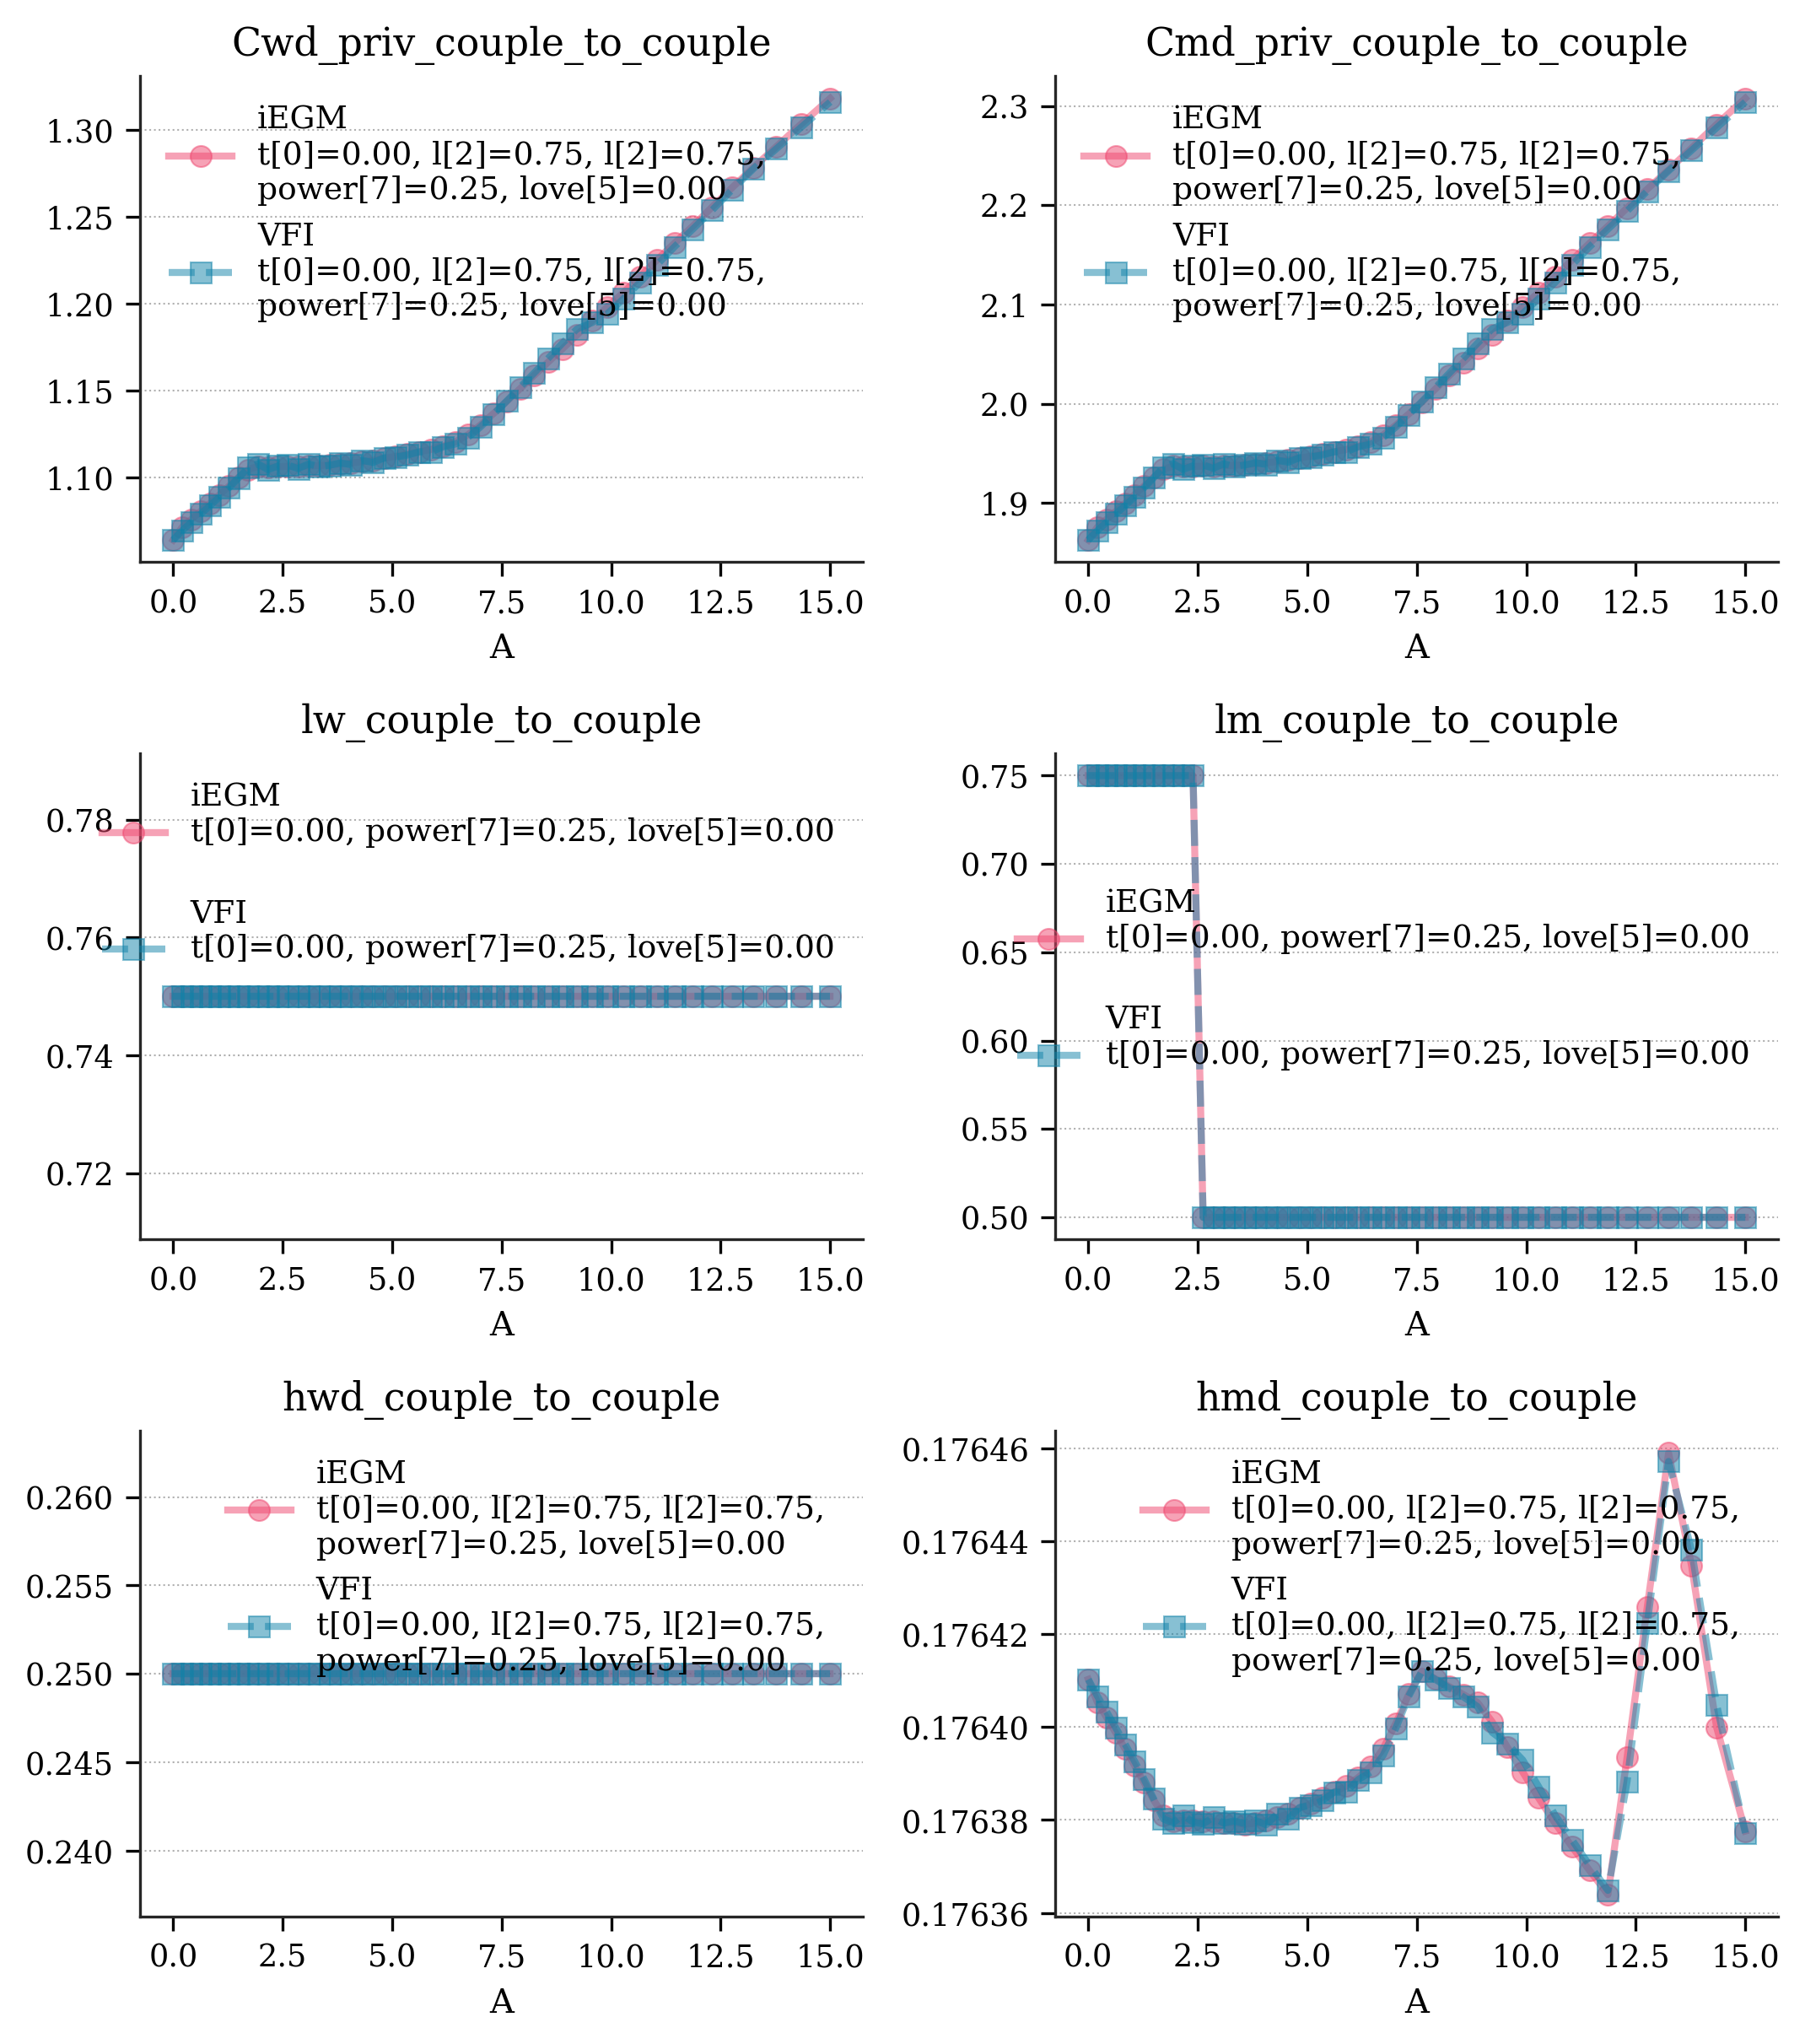

In [13]:
fig, ax = fm.create_figure(3,2,6)
if show_iEGM:    mp_iEGM.plot_gender_couple_choices(ax, grid=grid, index=idx, alpha=0.5)
if show_VFI:     mp_VFI.plot_gender_couple_choices(ax, grid=grid, index=idx, alpha=0.5)
if show_numEGM:  mp_numEGM.plot_gender_couple_choices(ax, grid=grid, index=idx, alpha=0.5)
if show_iEGMinv: mp_iEGMinv.plot_gender_couple_choices(ax, grid=grid, index=idx, alpha=0.5)
fm.save_figure(filename="gender_couple_choices")

Saved full figure to output\total_couple_choices.pdf
Saved subplot to output\total_couple_choices_subplot_1.pdf
Saved subplot to output\total_couple_choices_subplot_2.pdf
Saved subplot to output\total_couple_choices_subplot_3.pdf


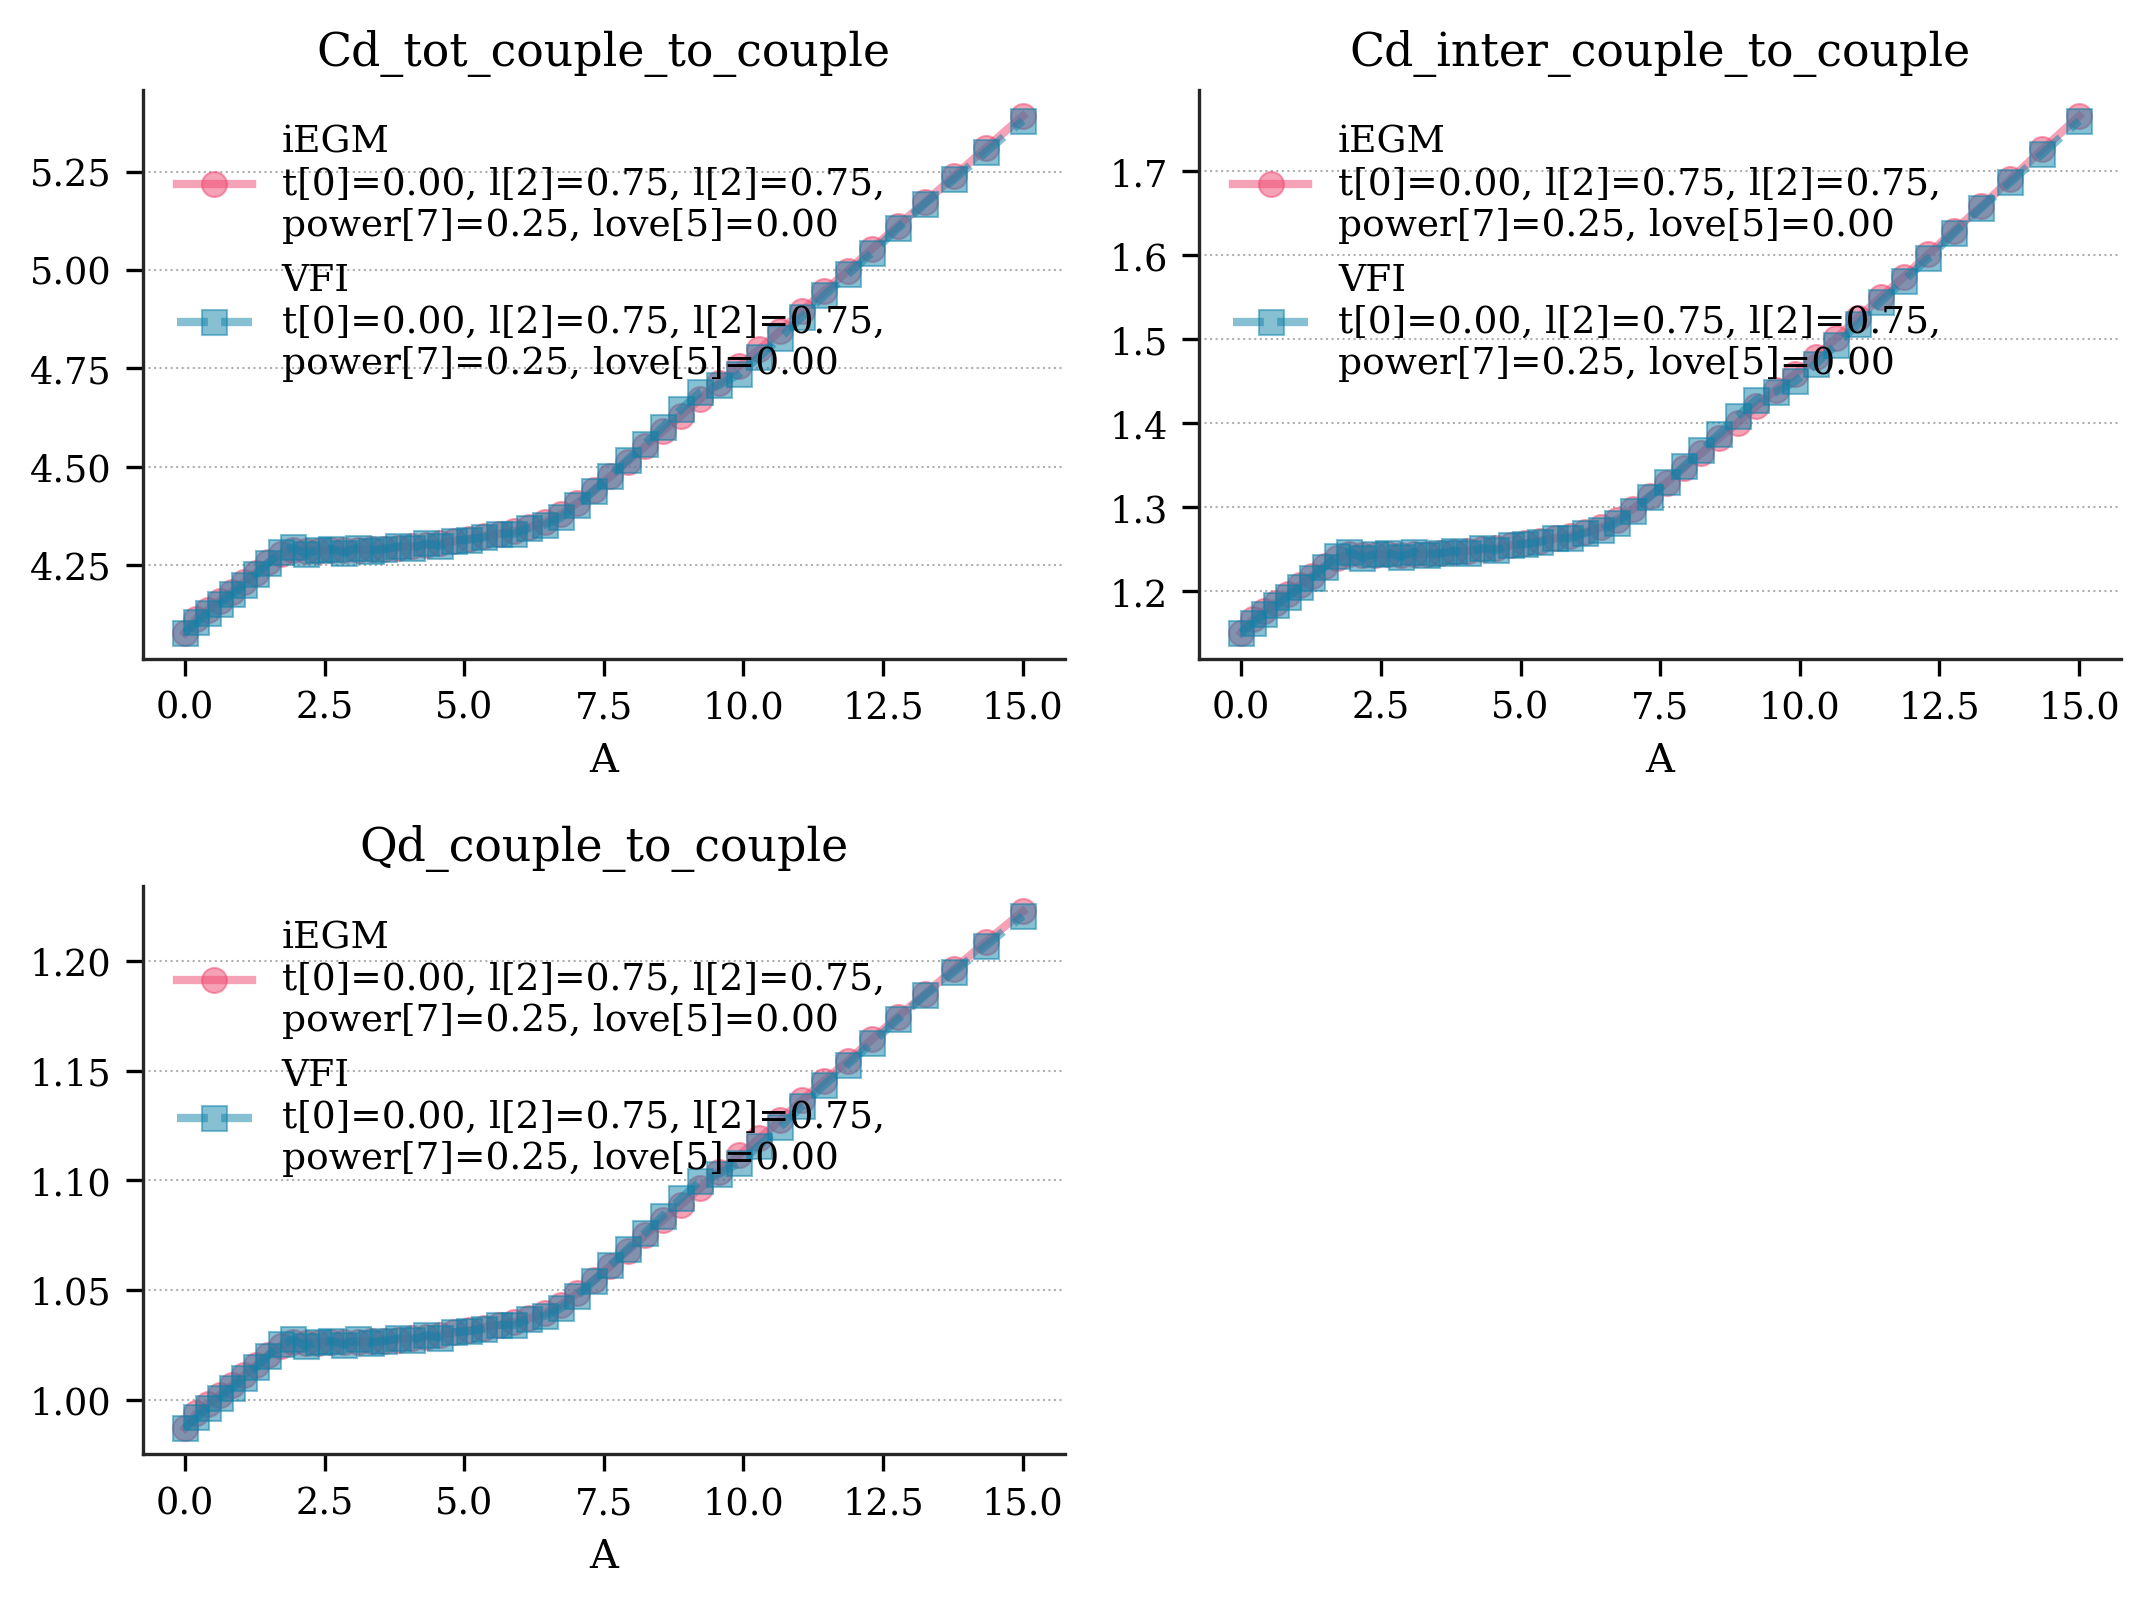

In [14]:
fig, ax = fm.create_figure(2,2,3)
if show_iEGM:    mp_iEGM.plot_total_couple_choices(ax, grid=grid, index=idx, alpha=0.5)
if show_VFI:     mp_VFI.plot_total_couple_choices(ax, grid=grid, index=idx, alpha=0.5)
if show_numEGM:  mp_numEGM.plot_total_couple_choices(ax, grid=grid, index=idx, alpha=0.5)
if show_iEGMinv: mp_iEGMinv.plot_total_couple_choices(ax, grid=grid, index=idx, alpha=0.5)
fm.save_figure(filename="total_couple_choices")


Saved full figure to output\female_couple_values.pdf
Saved subplot to output\female_couple_values_subplot_1.pdf
Saved subplot to output\female_couple_values_subplot_2.pdf
Saved subplot to output\female_couple_values_subplot_3.pdf
Saved subplot to output\female_couple_values_subplot_4.pdf


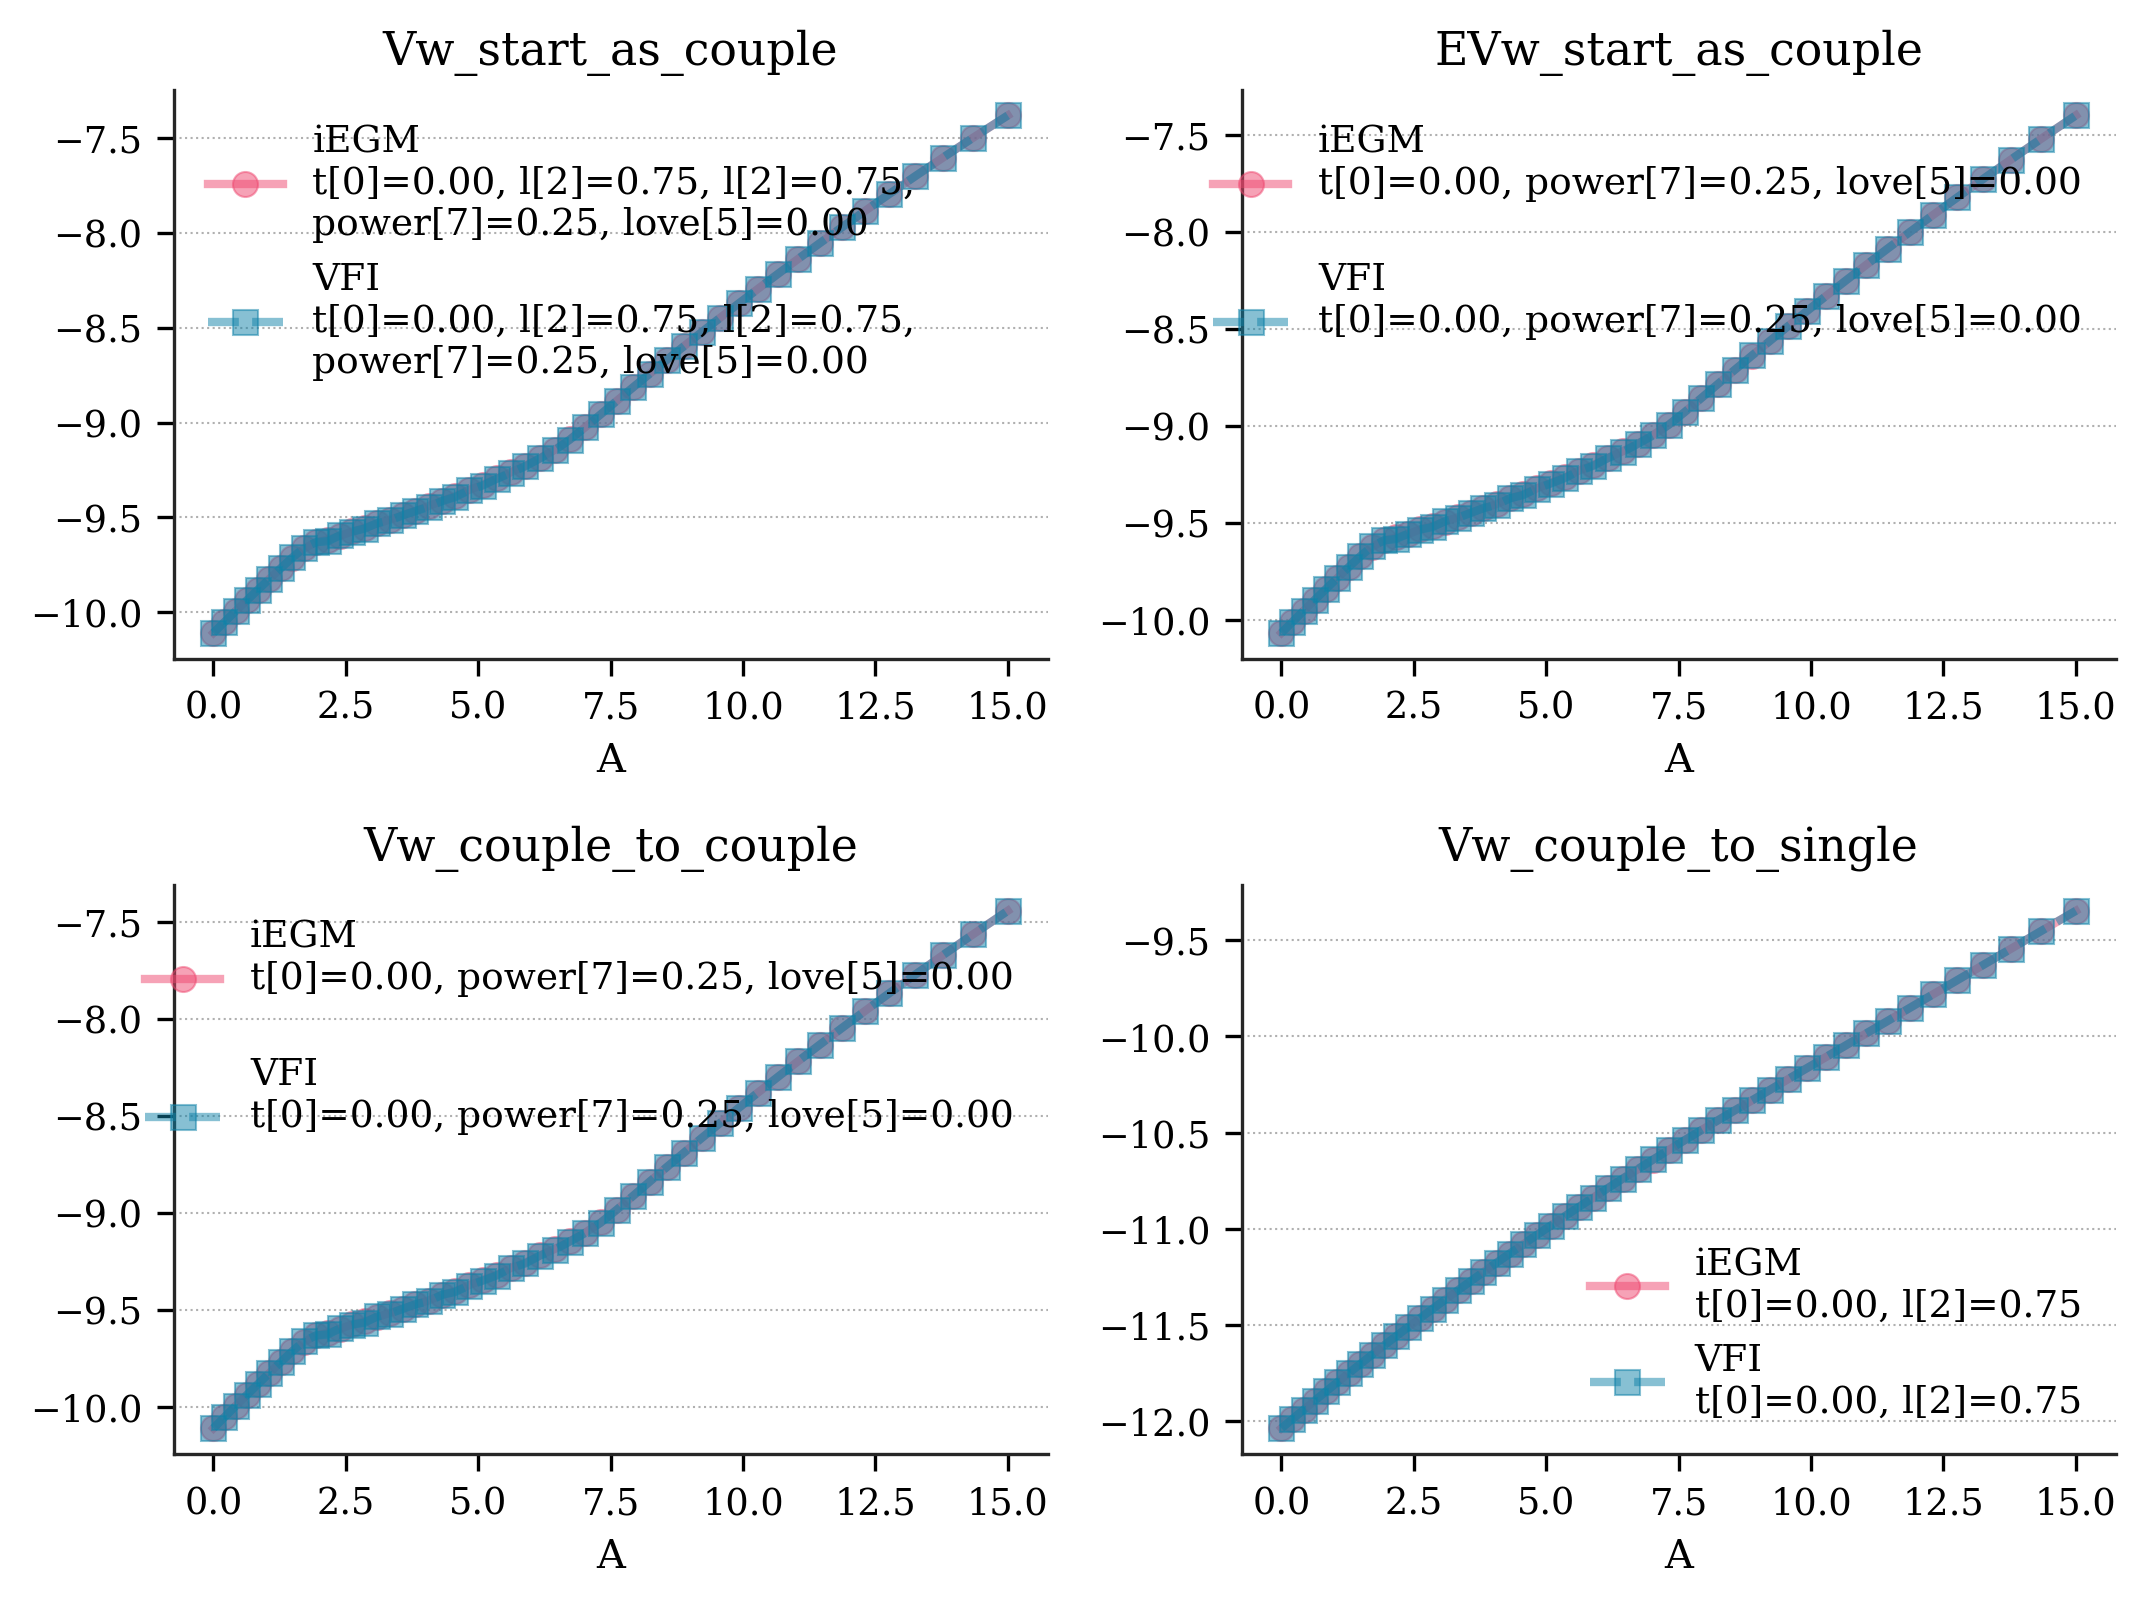

In [15]:
fig, ax = fm.create_figure(2,2,4)
if show_iEGM:    mp_iEGM.plot_female_couple_values(ax, grid=grid, index=idx, alpha=0.5)
if show_VFI:     mp_VFI.plot_female_couple_values(ax, grid=grid, index=idx, alpha=0.5)
if show_numEGM:  mp_numEGM.plot_female_couple_values(ax, grid=grid, index=idx, alpha=0.5)
if show_iEGMinv: mp_iEGMinv.plot_female_couple_values(ax, grid=grid, index=idx, alpha=0.5)
fm.save_figure(filename="female_couple_values")


Saved full figure to output\total_couple_values.pdf
Saved subplot to output\total_couple_values_subplot_1.pdf
Saved subplot to output\total_couple_values_subplot_2.pdf
Saved subplot to output\total_couple_values_subplot_3.pdf
Saved subplot to output\total_couple_values_subplot_4.pdf


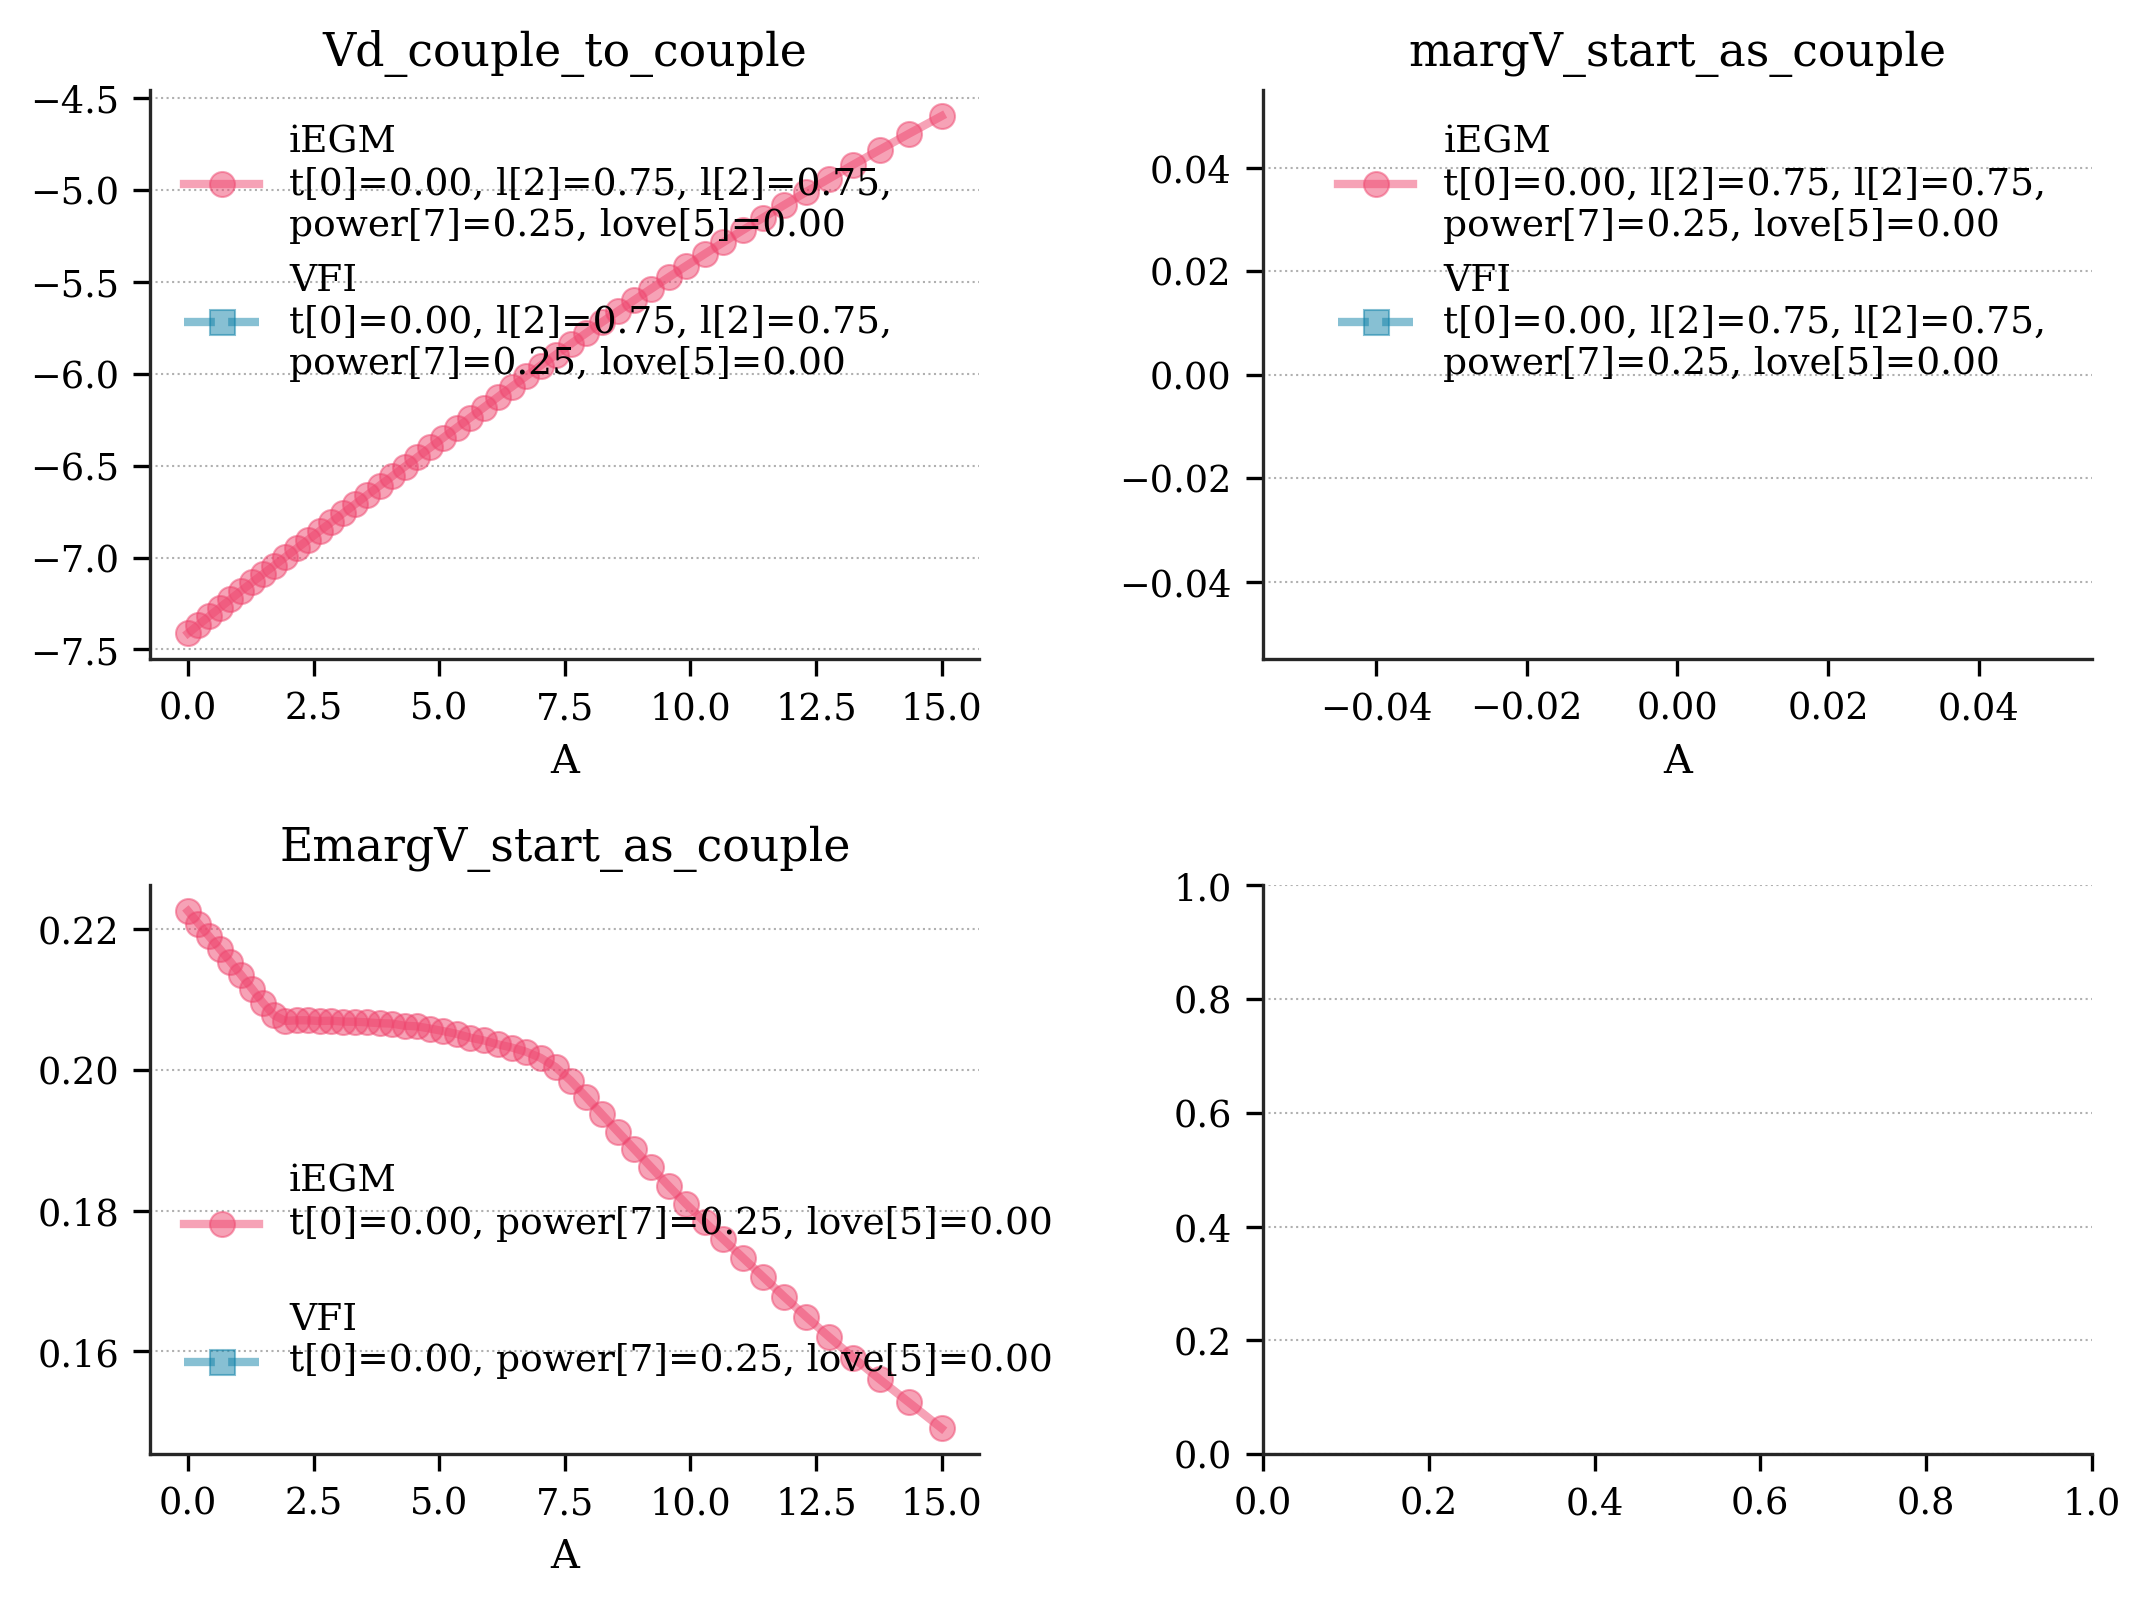

In [16]:
fig, ax = fm.create_figure(2,2,4)
if show_iEGM:    mp_iEGM.plot_total_couple_values(ax, grid=grid, index=idx, alpha=0.5)
if show_VFI:     mp_VFI.plot_total_couple_values(ax, grid=grid, index=idx, alpha=0.5)
if show_numEGM:  mp_numEGM.plot_total_couple_values(ax, grid=grid, index=idx, alpha=0.5)
if show_iEGMinv: mp_iEGMinv.plot_total_couple_values(ax, grid=grid, index=idx, alpha=0.5)
fm.save_figure(filename="total_couple_values")


## Simulation

In [17]:
# fig, ax = fm.create_figure(2,2,4)

# ax[0].plot(np.arange(model.par.simT), np.nanmean(model.sim.couple, axis=0), label='couple')
# ax[1].plot(np.arange(model.par.simT), np.nanmean(model.sim.love, axis=0), label='love')
# ax[2].plot(np.arange(model.par.simT), np.nanmean(model.sim.power, axis=0), label='power')
# ax[3].plot(np.arange(model.par.simT), np.nanmean(model.sim.A, axis=0), label='A')

# ## add legend
# for a in ax:
#     a.legend()
#     a.set_xlabel('t')
#     a.set_ylabel('mean')
#     a.grid()
    
# fm.save_figure(filename="test")


## Precomputation: Singles

In [18]:
model = model_iEGM if show_iEGM else model_VFI 
par = model.par

AttributeError: 'types.SimpleNamespace' object has no attribute 'pre_Cw_priv_single'

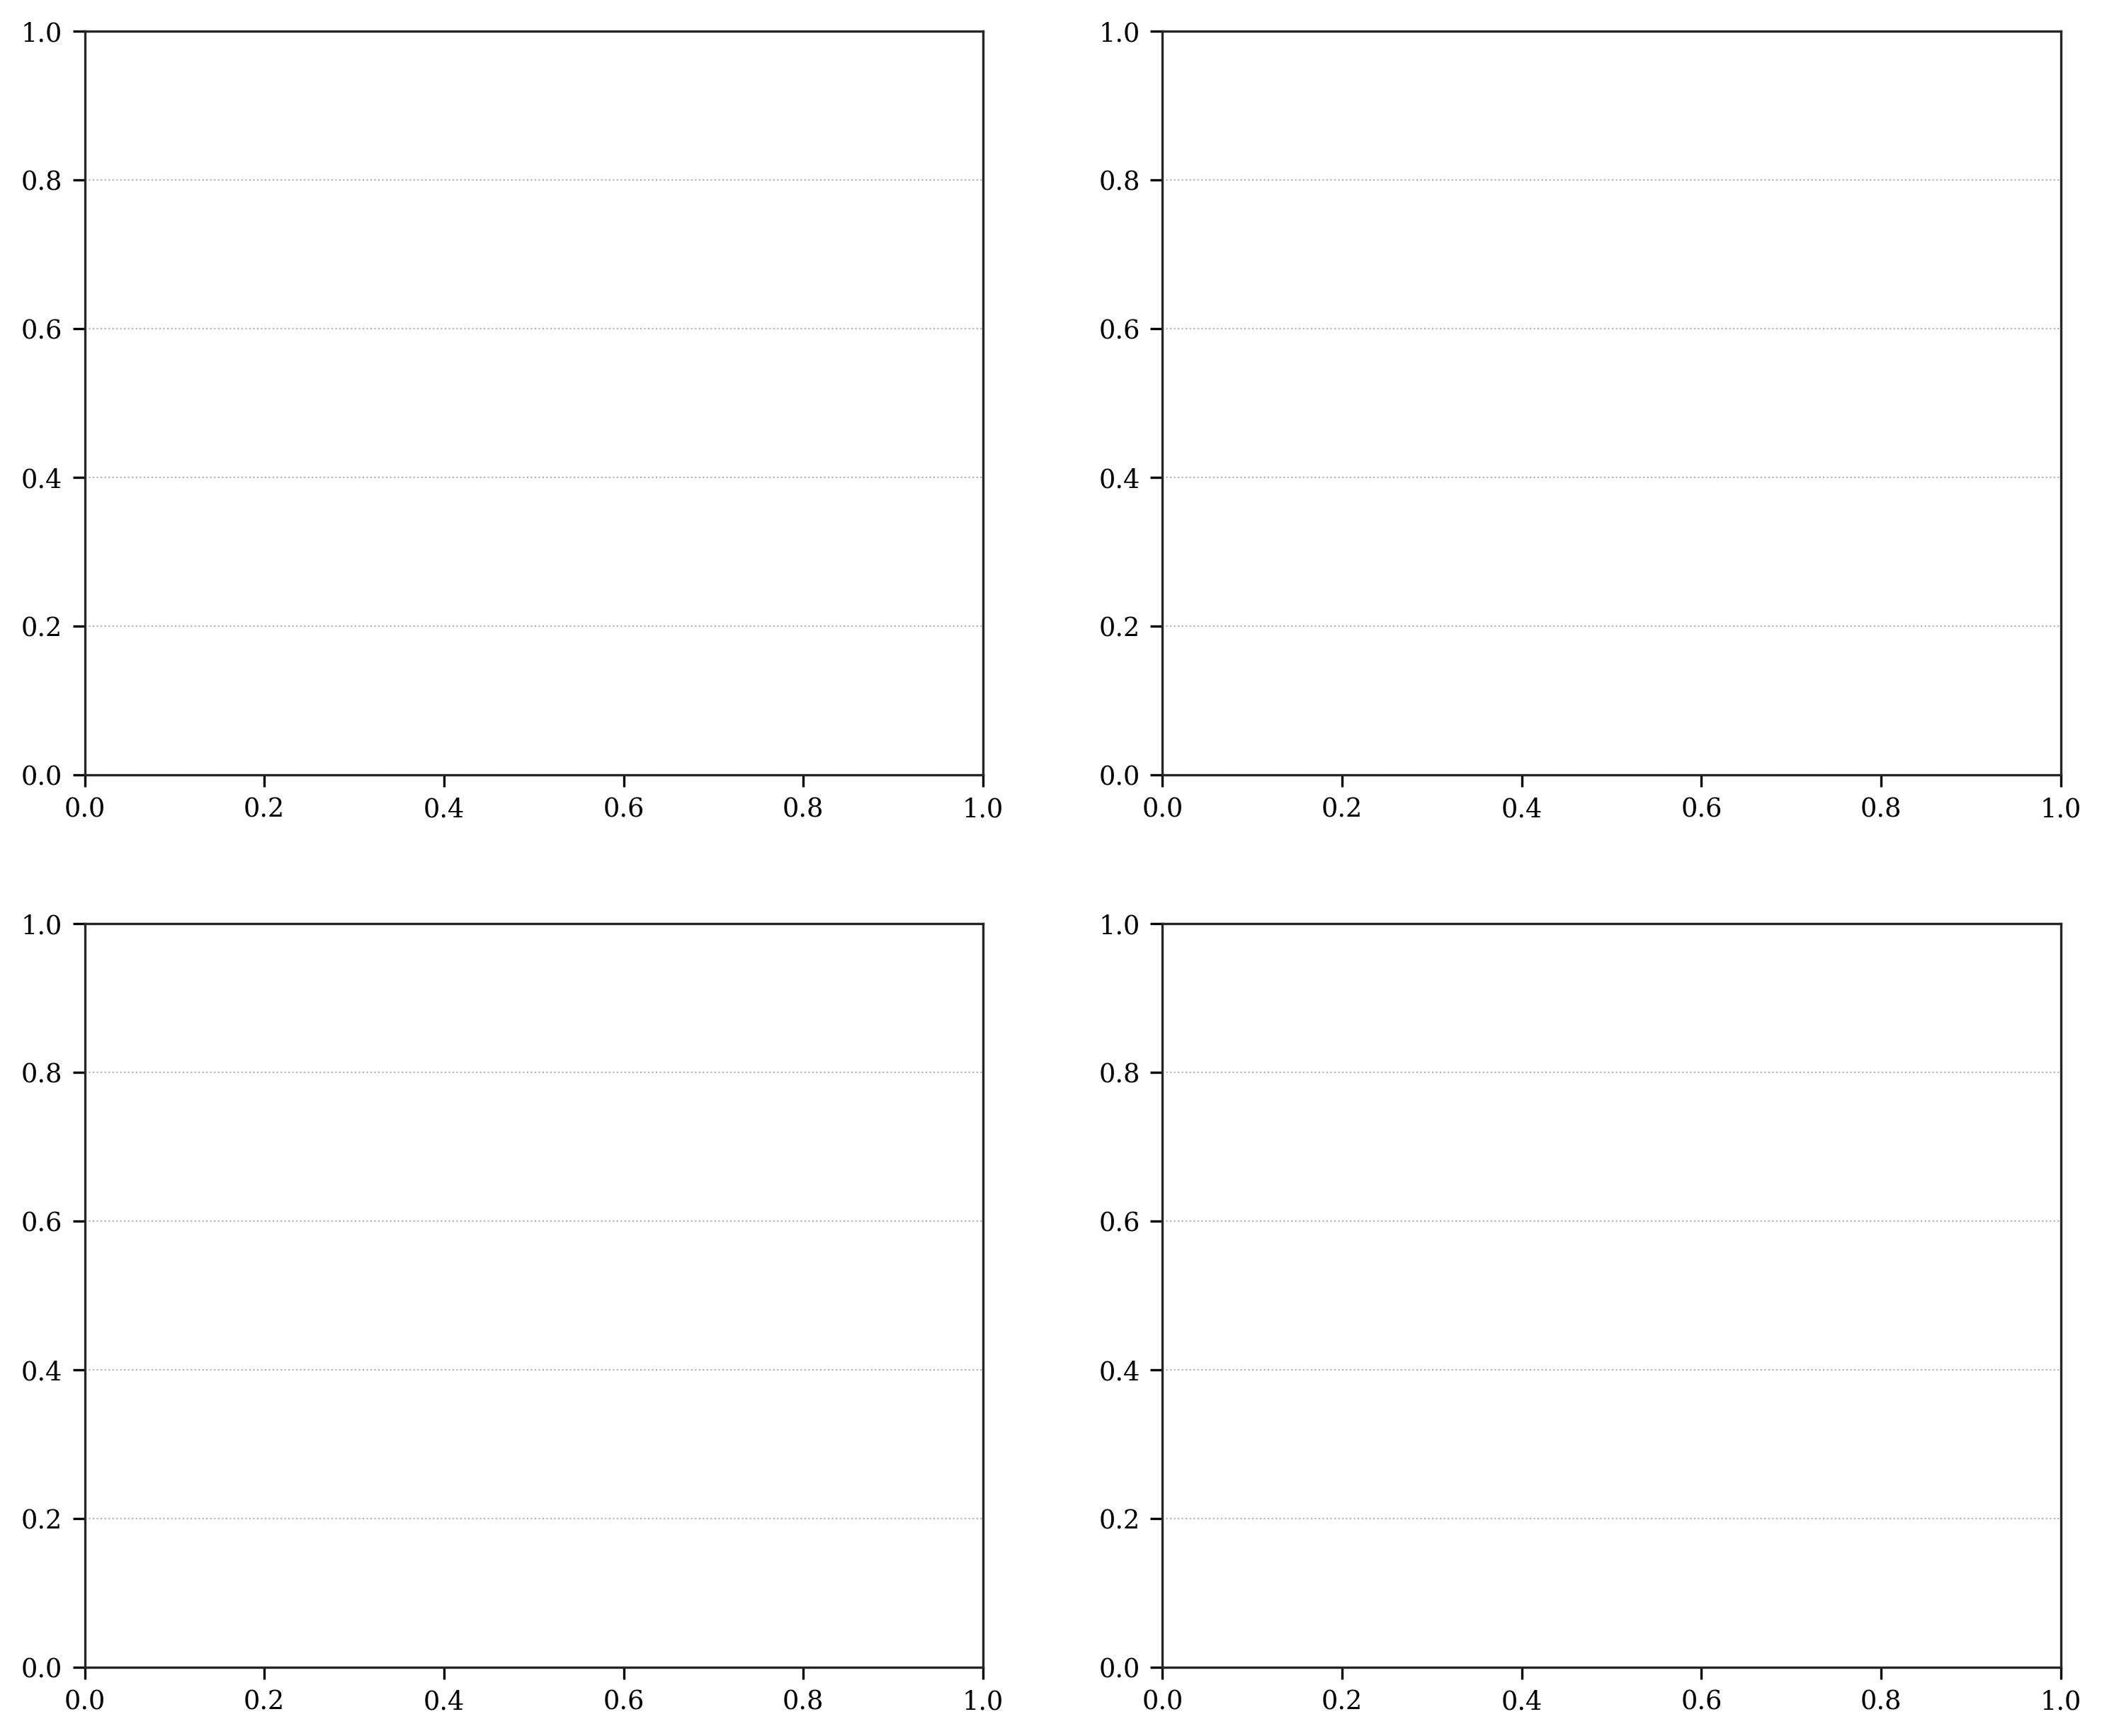

In [19]:
fig, ax = plt.subplots(2,2, figsize=(12,10))

for i,l in enumerate(model.par.grid_l):
    ax[0,0].plot(model.par.grid_Ctot, model.sol.pre_Cw_priv_single[i,:], label=f'l={l}')
    ax[0,0].set_title('c priv')
    ax[0,0].set_xlabel('Ctot')
    ax[0,0].legend()

    ax[0,1].plot(model.par.grid_Ctot, model.sol.pre_Cw_inter_single[i,:], label=f'l={l}')
    ax[0,1].set_title('c inter')
    ax[0,1].set_xlabel('Ctot')

    ax[1,0].plot(model.par.grid_Ctot[:], model.sol.pre_hw_single[i,:], label=f'l={l}')
    ax[1,0].set_title('h')
    ax[1,0].set_xlabel('Ctot')

    ax[1,1].plot(model.par.grid_Ctot, model.sol.pre_Qw_single[i,:], label=f'l={l}')
    ax[1,1].set_title('Q')
    ax[1,1].set_xlabel('Ctot')



AMO: h is constant in Ctot due to the Cobb Douglas production function giving cross elasticities of zero. with a more general production function, h depends on Ctot (I've checked this). This is also why marginal utility does not depend on labor supply, see below. 

In [ ]:
for il in range(par.num_l):
    plt.scatter(par.grid_C_for_marg_u[1:], par.grid_marg_u_single_m[il, 1:], label=f'l={par.grid_l[il]}')
plt.legend()
plt.xlabel('$C_t$')
plt.ylabel('$U\'$')
plt.title("Marginal utility, singles")

## Precomputation: Couples

In [ ]:
# model.cpp.delink()
# model.link_to_cpp(force_compile=do_compile, do_print=False)
# model.solve()

# par = model.par
# sol = model.sol

In [ ]:
getattr(model.sol, "pre_Cm_priv_couple").shape 

In [ ]:
def plot_variable_l_by_l(varname, container, iPs, x_axis):
    fig, ax = plt.subplots(3,3, figsize=(15,15))
    variable = getattr(container, varname)

    for ilw,lw in enumerate(model.par.grid_l):
        for ilm, lm in enumerate(model.par.grid_l):
            for iP in iPs:
                ax[ilw, ilm].plot(x_axis, variable[ilw, ilm, :, iP], label=f'p={par.grid_power[iP] :5.2f}')
                ax[ilw, ilm].scatter(x_axis, variable[ilw, ilm, :, iP], s=10)


            ax[ilw, ilm].set_title(f'lw={lw}, lm={lm}')
            ax[ilw, ilm].set_xlabel('Ctot')
            ax[ilw, ilm].legend()


iPs = [1, 5, 9]

In [ ]:
plot_variable_l_by_l('pre_Cm_priv_couple', model.sol, iPs, par.grid_Ctot)
plot_variable_l_by_l('pre_Cw_priv_couple', model.sol, iPs, par.grid_Ctot)

In [ ]:
plot_variable_l_by_l('pre_hm_couple', model.sol, iPs, par.grid_Ctot)
plot_variable_l_by_l('pre_hw_couple', model.sol, iPs, par.grid_Ctot)

In [ ]:
plot_variable_l_by_l('grid_marg_u_couple', model.par, [1, 3, 6], model.par.grid_C_for_marg_u)